In [4]:
from matplotlib import pyplot
from keras import layers
from keras import models
from keras.datasets import cifar10
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPool2D, Activation, MaxPooling2D
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, auc, roc_curve
from keras.optimizers import Adam, SGD

import matplotlib.pyplot as plt
import numpy as np

In [5]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

In [6]:
train_norm = trainX.astype('float32')
test_norm = testX.astype('float32')
train_norm = train_norm / 255.0
test_norm = test_norm / 255.0

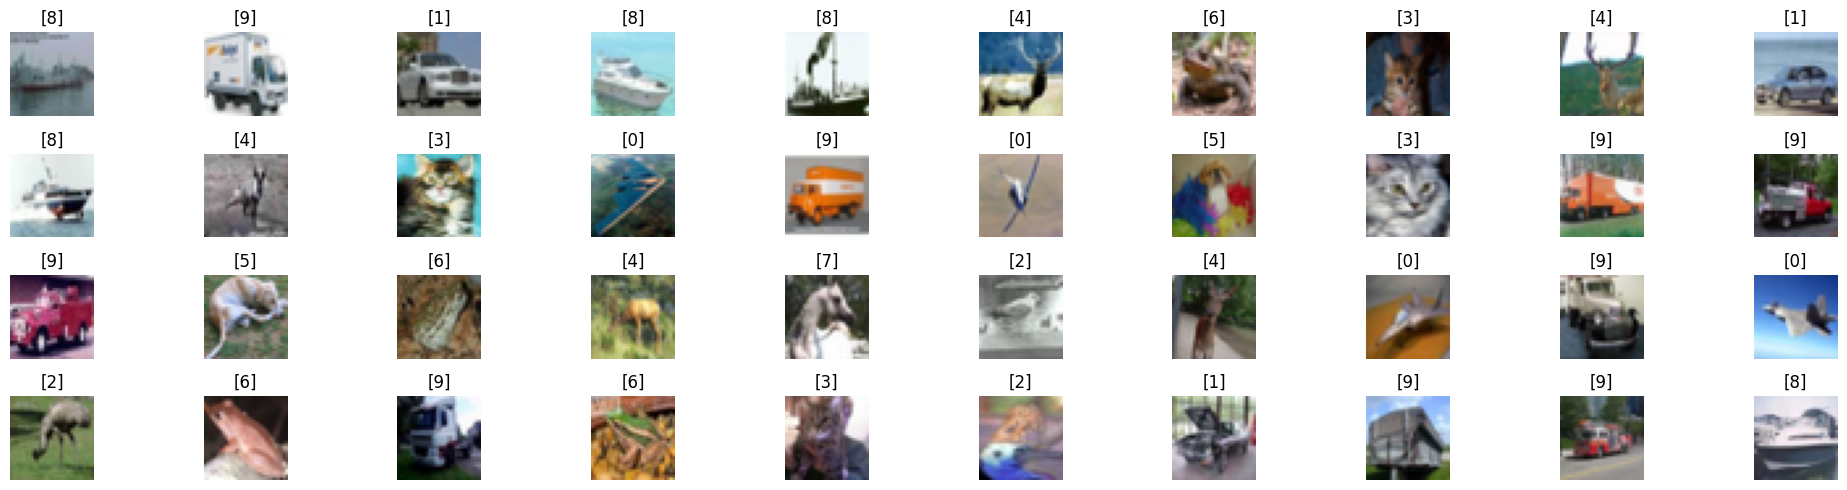

In [7]:
def draw_sample_images(data, labels = False):
    nrows = 4
    ncols = 10

    total_image = data.shape[0]


    samples = np.random.choice(total_image, nrows*ncols)

    plt.figure(figsize=(20, 5))
    for i in range(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(data[samples[i]])
        if(labels):
            plt.title(trainY[samples[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


draw_sample_images(trainX, labels = True)

In [8]:
from keras.utils import to_categorical

trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [16]:
model = Sequential()
model.add(Conv2D(32,  kernel_size = 3,kernel_initializer='he_normal', activation='relu', input_shape = (32, 32, 3)))
model.add(BatchNormalization())

model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size = 3, kernel_initializer='he_normal', strides=1, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, kernel_size = 3, strides=1, kernel_initializer='he_normal' ,padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, kernel_size = 3,kernel_initializer='he_normal', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D((4, 4)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256,kernel_initializer='he_normal', activation = "relu"))
model.add(Dropout(0.1))
model.add(Dense(10, kernel_initializer='glorot_uniform', activation = "softmax"))


In [17]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_8 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)       

In [18]:
earlystopper = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5,
                              verbose=1, mode='max', min_lr=0.00001)

history=model.fit(
        x=trainX,
        y=trainY,
        batch_size=32,
        epochs=50,
        verbose=1,
        callbacks=[earlystopper, reduce_lr],
        validation_split=0.2
)

Epoch 1/50
1250/1250 [==============================] - 14s 8ms/step - loss: 1.7730 - accuracy: 0.3746 - val_loss: 1.5343 - val_accuracy: 0.4522 - lr: 0.0010
Epoch 2/50
1250/1250 [==============================] - 9s 8ms/step - loss: 1.2769 - accuracy: 0.5439 - val_loss: 1.1713 - val_accuracy: 0.5810 - lr: 0.0010
Epoch 3/50
1250/1250 [==============================] - 11s 8ms/step - loss: 1.0742 - accuracy: 0.6211 - val_loss: 1.0108 - val_accuracy: 0.6361 - lr: 0.0010
Epoch 4/50
1250/1250 [==============================] - 11s 8ms/step - loss: 0.9366 - accuracy: 0.6718 - val_loss: 0.9332 - val_accuracy: 0.6817 - lr: 0.0010
Epoch 5/50
1250/1250 [==============================] - 10s 8ms/step - loss: 0.8317 - accuracy: 0.7086 - val_loss: 0.8736 - val_accuracy: 0.6919 - lr: 0.0010
Epoch 6/50
1250/1250 [==============================] - 11s 9ms/step - loss: 0.7608 - accuracy: 0.7347 - val_loss: 0.8238 - val_accuracy: 0.7115 - lr: 0.0010
Epoch 7/50
1250/1250 [==============================]

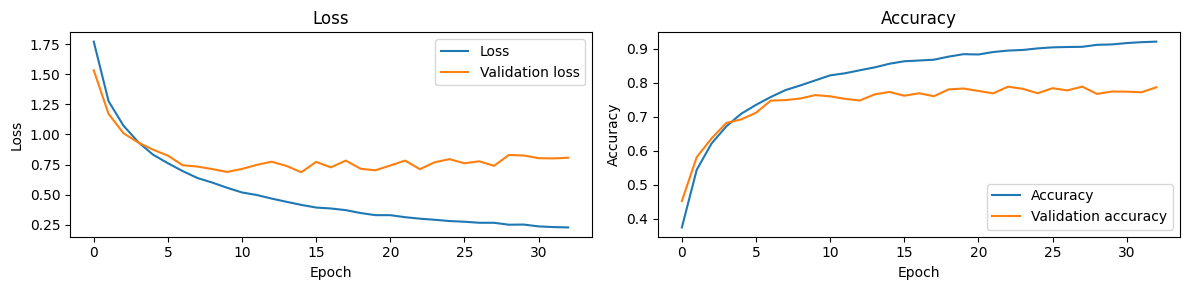

In [19]:
f, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].plot(history.history['loss'], label="Loss")
ax[0].plot(history.history['val_loss'], label="Validation loss")
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Accuracy
ax[1].plot(history.history['accuracy'], label="Accuracy")
ax[1].plot(history.history['val_accuracy'], label="Validation accuracy")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

In [20]:
y_pred_raw = model.predict(testX)
y_pred = np.argmax(y_pred_raw, axis=1)
y_true = np.argmax(testY, axis = 1)

313/313 [==============================] - 1s 3ms/step


In [21]:
print(f"Test accuracy is {np.mean(y_true == y_pred)}%")

print("Confusion Matrix")
print(confusion_matrix(y_true,y_pred ))
print('F1 score is',f1_score(y_true,y_pred, average = 'weighted') *100, "%")

predicted_probab =model.predict(testX)
print("ROC- AUC score is", roc_auc_score(testY, predicted_probab)*100)

Test accuracy is 0.7777%
Confusion Matrix
[[790  15  54  22  11   7  12  17  48  24]
 [ 13 904   6   1   1   9  11   2   8  45]
 [ 47   4 680  52  59  59  69  21   2   7]
 [ 12   5  52 597  49 201  45  22   7  10]
 [ 14   0  51  54 730  45  46  56   3   1]
 [  9   2  47  90  29 776  14  29   2   2]
 [  7   4  33  42  20  27 855  10   0   2]
 [ 13   2  33  44  42  64   8 780   2  12]
 [ 69  29  19  12   3   5  16   4 815  28]
 [ 19  72  12  14   2   5  10   5  11 850]]
F1 score is 77.78797699686318 %
313/313 [==============================] - 1s 4ms/step
ROC- AUC score is 97.3840738888889
